In [68]:
import os
import re
import math
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from tools.settings import *
from keras.models import Sequential
from keras.preprocessing import image
from keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tools.train_val_test_spliter import split

### Pre Processing

In [69]:
train = pd. read_csv(os.path.join(dataset_path, "train.csv"))
test = pd. read_csv(os.path.join(dataset_path, "test.csv"))
val = pd. read_csv(os.path.join(dataset_path, "val.csv"))

In [70]:
# To split dataset if already splits folder already exits no need to run it
split()

Splitting the ginen dataset into Train Test=0.2 Validation=0.2
Done


In [71]:
train.head()

,Video_url,action
0,H:/THESIS/dataset\kick/kick_175.wmv,kick
1,H:/THESIS/dataset\punch/punch_49.mp4,punch
2,H:/THESIS/dataset\kick/kick_92.mp4,kick
3,H:/THESIS/dataset\slap/slap_10.mp4,slap
4,H:/THESIS/dataset\punch/punch_179.mp4,punch


In [72]:
test.head()

,Video_url,action
0,H:/THESIS/dataset\punch/punch_31.mp4,punch
1,H:/THESIS/dataset\punch/punch_47.mp4,punch
2,H:/THESIS/dataset\kick/kick_28.mp4,kick
3,H:/THESIS/dataset\kick/kick_62.mp4,kick
4,H:/THESIS/dataset\slap/Slap_141.mp4,slap


In [73]:
val.head()

,Video_url,action
0,H:/THESIS/dataset\kick/kick_113.mp4,kick
1,H:/THESIS/dataset\slap/slap_129.mp4,slap
2,H:/THESIS/dataset\punch/punch_56.mp4,punch
3,H:/THESIS/dataset\kick/kick_68.mp4,kick
4,H:/THESIS/dataset\slap/Slap_146.mp4,slap


In [74]:
print(train.shape)
print(test.shape)
print(val.shape)

(370, 2)
(123, 2)
(123, 2)


In [75]:
def convert_to_frame(data, folder_name):
    '''
    Generated filenames format dataset_path/folder_name/video_name_frame{number}_action.jpg
    '''
    directory = os.path.join(dataset_path, folder_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    for i in tqdm(range(data.shape[0])):
        video_file = data['Video_url'][i]
        action = data['action'][i]
        video_name_list = video_file.split('/')[-1].split('.')
        video_name_list = video_name_list[:-1]
        video_name = ""
        for n in video_name_list:
            video_name += n
        # capturing the video from the given path
        capture = cv2.VideoCapture(video_file) 
        #frame rate
        frame_rate = capture.get(5)
        count = 0
        while(capture.isOpened()):
            #current frame number
            frame_id = capture.get(1) 
            read_correctly, frame = capture.read()
            if not read_correctly:
                break
            if (frame_id % math.floor(frame_rate) == 0):
                # storing the frames in a new folder named train_1
                filename = directory + "/" + video_name + "_frame{}_".format(count) + action +".jpg"
                count += 1
                cv2.imwrite(filename, frame)
        capture.release()
    print("Successfully Converted")

In [76]:
convert_to_frame(train, train_frames_path_name)

100%|████████████████████████████████████████████████████████████████████████████████| 370/370 [03:13<00:00,  1.91it/s]

Successfully Converted


In [77]:
convert_to_frame(val, val_frames_path_name)

100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [01:05<00:00,  1.89it/s]

Successfully Converted


In [78]:
def create_paths_csv(directory, file_name):
    images = os.listdir(directory)
    images_path_list = []
    images_action_list = [] 
    for image in images:
        images_path_list.append(directory + image)
        images_action_list.append(image.split('.')[0].split('_')[-1])
    df = pd.DataFrame()
    df['image'] = images_path_list
    df['action'] = images_action_list
    print(os.path.join(dataset_path, file_name+'.csv'))
    df.to_csv(os.path.join(dataset_path, file_name+'.csv'), index=False)

In [79]:
create_paths_csv(train_frames_path, train_frames_path_name)

H:/THESIS/dataset\train_frames.csv


In [80]:
create_paths_csv(val_frames_path, val_frames_path_name)

H:/THESIS/dataset\val_frames.csv


In [81]:
train_image = pd.read_csv(os.path.join(dataset_path, 'train_frames.csv'))
train_image.head()

,image,action
0,H:/THESIS/dataset\train_frames\kick_02_frame0_...,kick
1,H:/THESIS/dataset\train_frames\kick_02_frame1_...,kick
2,H:/THESIS/dataset\train_frames\kick_03_frame0_...,kick
3,H:/THESIS/dataset\train_frames\kick_03_frame1_...,kick
4,H:/THESIS/dataset\train_frames\kick_03_frame2_...,kick


In [82]:
print(train_image.shape)

(2117, 2)


In [83]:
val_image = pd.read_csv(os.path.join(dataset_path, 'val_frames.csv'))
val_image.head()

,image,action
0,H:/THESIS/dataset\val_frames\kick_01_frame0_ki...,kick
1,H:/THESIS/dataset\val_frames\kick_01_frame1_ki...,kick
2,H:/THESIS/dataset\val_frames\kick_01_frame2_ki...,kick
3,H:/THESIS/dataset\val_frames\kick_01_frame3_ki...,kick
4,H:/THESIS/dataset\val_frames\kick_05_frame0_ki...,kick


In [84]:
print(val_image.shape)

(934, 2)


In [85]:
action_values = list(train_image['action'].unique())
action_values

['kick', 'punch', 'slap']

In [86]:
def create_class_columns(df):
    for value in action_values:
        df[value] = np.where(df['action'].str.contains(value), 1, 0)
    df.drop('action', axis='columns', inplace=True)

In [87]:
create_class_columns(train_image)
train_image.head()

,image,kick,punch,slap
0,H:/THESIS/dataset\train_frames\kick_02_frame0_...,1,0,0
1,H:/THESIS/dataset\train_frames\kick_02_frame1_...,1,0,0
2,H:/THESIS/dataset\train_frames\kick_03_frame0_...,1,0,0
3,H:/THESIS/dataset\train_frames\kick_03_frame1_...,1,0,0
4,H:/THESIS/dataset\train_frames\kick_03_frame2_...,1,0,0


In [88]:
create_class_columns(val_image)
val_image.head()

,image,kick,punch,slap
0,H:/THESIS/dataset\val_frames\kick_01_frame0_ki...,1,0,0
1,H:/THESIS/dataset\val_frames\kick_01_frame1_ki...,1,0,0
2,H:/THESIS/dataset\val_frames\kick_01_frame2_ki...,1,0,0
3,H:/THESIS/dataset\val_frames\kick_01_frame3_ki...,1,0,0
4,H:/THESIS/dataset\val_frames\kick_05_frame0_ki...,1,0,0


In [89]:
def convert_to_array_and_split(image_data):
    image_value = []
    for i in tqdm(range(image_data.shape[0])):
        img = image.load_img(image_data['image'][i], target_size=(224,224,3))
        img = image.img_to_array(img)
        # normalizing the pixel value
        img = img / 255
        image_value.append(img)

    X = np.array(image_value)
    y = image_data
    y.drop('image', axis='columns', inplace=True)
    return X, y

In [90]:
X_train, y_train = convert_to_array_and_split(train_image)
print(X_train.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 2117/2117 [00:29<00:00, 71.75it/s]


(2117, 224, 224, 3)


In [91]:
X_val, y_val = convert_to_array_and_split(val_image)
print(X_val.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 934/934 [00:21<00:00, 43.53it/s]


(934, 224, 224, 3)


In [92]:
y_train.head()

,kick,punch,slap
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [93]:
y_val.head()

,kick,punch,slap
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


### Processing With Pre-trained VGG16 with imagenet weight

In [94]:
from keras.applications.vgg16 import VGG16
'''This model was trained on a dataset that has 1,000 classes. 
include_top = False will remove the last layer of this model so that we can tune it as per our need.
'''
base_model = VGG16(weights='imagenet', include_top=False)

In [95]:
# extracting features for training frames
X_train = base_model.predict(X_train)
X_train.shape

(2117, 7, 7, 512)

In [96]:
X_val = base_model.predict(X_val)
X_val.shape

(934, 7, 7, 512)

In [97]:
# reshaping the training as well as validation frames in single dimension
X_train = X_train.reshape(2117, 7*7*512)
X_val = X_val.reshape(934, 7*7*512)

In [98]:
# normalizing the pixel values
max_pixel = X_train.max()
X_train = X_train / max_pixel
X_val = X_val / max_pixel
print(X_train.shape)
print(X_val.shape)

(2117, 25088)
(934, 25088)


### Deep Neural Network model with 5 layers and3 output neurons

In [99]:
# The input shape will be 25,088
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(25088,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

In [100]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_weight = ModelCheckpoint('weight3.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [50]:
model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[mcp_weight], batch_size=128)

Epoch 1/50
12/12 [==============================] - 2s 177ms/step - loss: 0.0203 - accuracy: 0.9915 - val_loss: 1.4238 - val_accuracy: 0.7821
Epoch 2/50
12/12 [==============================] - 2s 164ms/step - loss: 0.0199 - accuracy: 0.9922 - val_loss: 1.5538 - val_accuracy: 0.7821
Epoch 3/50
12/12 [==============================] - 2s 188ms/step - loss: 0.0204 - accuracy: 0.9922 - val_loss: 1.7297 - val_accuracy: 0.7665
Epoch 4/50
12/12 [==============================] - 3s 215ms/step - loss: 0.0403 - accuracy: 0.9850 - val_loss: 1.2182 - val_accuracy: 0.7860
Epoch 5/50
12/12 [==============================] - 2s 197ms/step - loss: 0.0544 - accuracy: 0.9804 - val_loss: 0.9719 - val_accuracy: 0.7996
Epoch 6/50
12/12 [==============================] - 2s 190ms/step - loss: 0.0520 - accuracy: 0.9784 - val_loss: 1.0115 - val_accuracy: 0.7918
Epoch 7/50
12/12 [==============================] - 2s 177ms/step - loss: 0.0346 - accuracy: 0.9889 - val_loss: 1.2286 - val_accuracy: 0.7763
Epoch 

In [101]:
history=model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[mcp_weight], batch_size=128)

Epoch 1/50
17/17 [==============================] - 8s 490ms/step - loss: 1.1957 - accuracy: 0.3585 - val_loss: 1.0791 - val_accuracy: 0.4486
Epoch 2/50
17/17 [==============================] - 6s 350ms/step - loss: 1.1111 - accuracy: 0.3722 - val_loss: 1.0663 - val_accuracy: 0.5203
Epoch 3/50
17/17 [==============================] - 6s 329ms/step - loss: 1.0482 - accuracy: 0.4199 - val_loss: 0.9361 - val_accuracy: 0.5514
Epoch 4/50
17/17 [==============================] - 6s 333ms/step - loss: 0.9387 - accuracy: 0.5158 - val_loss: 0.8234 - val_accuracy: 0.6135
Epoch 5/50
17/17 [==============================] - 6s 356ms/step - loss: 0.8302 - accuracy: 0.5923 - val_loss: 0.7229 - val_accuracy: 0.6520
Epoch 6/50
17/17 [==============================] - 6s 338ms/step - loss: 0.7237 - accuracy: 0.6429 - val_loss: 0.6014 - val_accuracy: 0.7377
Epoch 7/50
17/17 [==============================] - 6s 345ms/step - loss: 0.5639 - accuracy: 0.7534 - val_loss: 0.4616 - val_accuracy: 0.8062
Epoch 

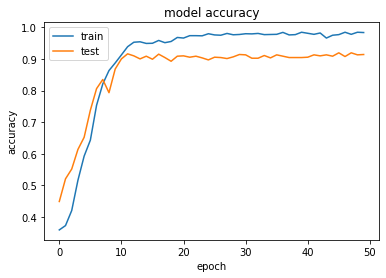

In [102]:
# summarize history for accuracy(2nd Run)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

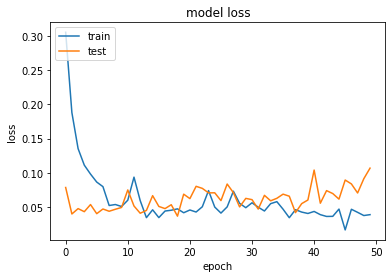

In [67]:
# summarize history for loss(1st Run)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() 

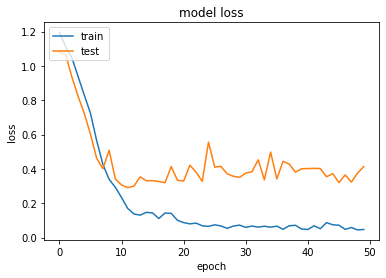

In [103]:
# summarize history for loss(2nd Run)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Applying Built model  on Test data and calculate accuracy with VGG16 

In [63]:
model.load_weights("weight.hdf5")
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

In [18]:
from scipy import stats as s
predict = []
actual = []
if not os.path.exists(test_frames_path):
    os.makedirs(test_frames_path)

for i in tqdm(range(test.shape[0])):
    video_file = test['Video_url'][i]
    action = test['action'][i]
    video_name_list = video_file.split('/')[-1].split('.')
    video_name_list = video_name_list[:-1]
    video_name = ""
    for n in video_name_list:
        video_name += n
    # capturing the video from the given path
    capture = cv2.VideoCapture(video_file) 
    #frame rate
    frame_rate = capture.get(5)
    count = 0
    files = glob(test_frames_path + '/*')
    #removing all files from folder
    for f in files:
        os.remove(f)
    while(capture.isOpened()):
        #current frame number
        frame_id = capture.get(1) 
        read_correctly, frame = capture.read()
        if not read_correctly:
            break
        if (frame_id % math.floor(frame_rate) == 0):
            # storing the frames in a new folder named train_1
            filename = test_frames_path + "/" + video_name + "_frame{}_".format(count) + action +".jpg"
            count += 1
            cv2.imwrite(filename, frame)
    capture.release()
    
    # reading all the frames from temp folder
    images = glob(test_frames_path + '/*.jpg')
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img / 255
        prediction_images.append(img)
        
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    # extracting features using pre-trained model
    prediction_images = base_model.predict(prediction_images)
    # converting features in one dimensional array
    prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*512)
    # predicting tags for each array
    prediction = np.argmax(model.predict(prediction_images), axis=-1)
    # appending the mode of predictions in predict list to assign the tag to the video
    predict.append(y_train.columns.values[s.mode(prediction)[0][0]])
    # appending the actual tag of the video
    actual.append(action)

100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [02:38<00:00,  1.29s/it]


In [89]:
y_train.columns.values[0]

'kick'

In [121]:
from sklearn.metrics import accuracy_score
accuracy_score(predict, actual)*100

92.6829268292683

In [20]:
from sklearn.metrics import precision_score
precision_score(actual, predict, average=None)

array([0.92682927, 0.88888889, 0.97297297])

In [21]:
precision_score(actual, predict, average='micro')

0.926829268292683

In [22]:
from sklearn.metrics import f1_score
f1_score(actual, predict, average=None)

array([0.9382716 , 0.90909091, 0.93506494])

In [23]:
f1_score(actual, predict, average='micro')

0.926829268292683

In [24]:
from sklearn.metrics import recall_score
recall_score(actual, predict, average=None)

array([0.95      , 0.93023256, 0.9       ])

In [25]:
recall_score(actual, predict, average='micro')

0.926829268292683

In [35]:
from sklearn.metrics import multilabel_confusion_matrix
confusion_matrix = multilabel_confusion_matrix(actual, predict, labels=action_values)
# confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
print(confusion_matrix)

[[[80  3]
  [ 2 38]]

 [[75  5]
  [ 3 40]]

 [[82  1]
  [ 4 36]]]


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

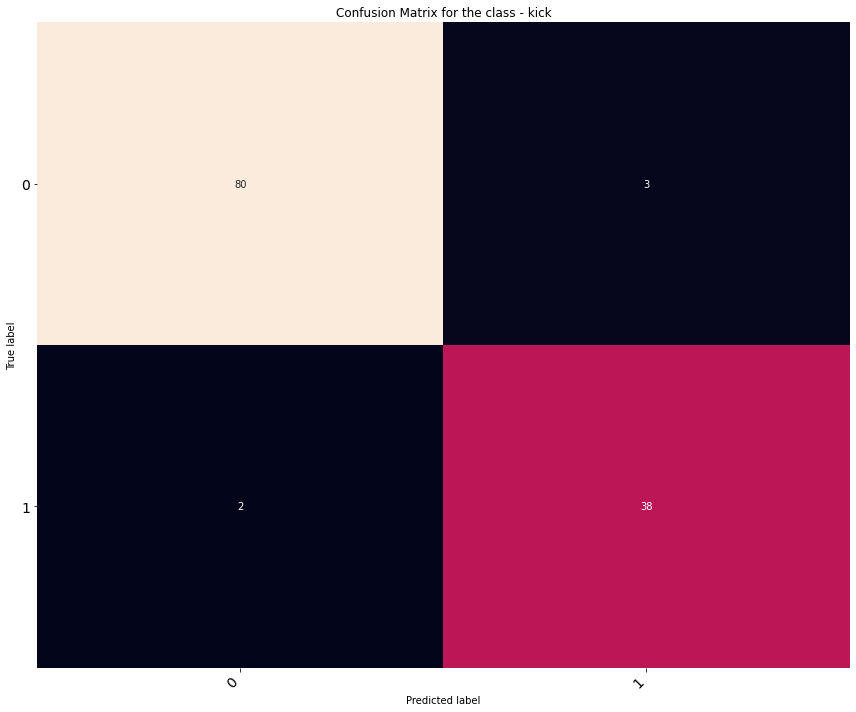

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
print_confusion_matrix(confusion_matrix[0], ax, action_values[0], ["0", "1"])
fig.tight_layout()
plt.show()

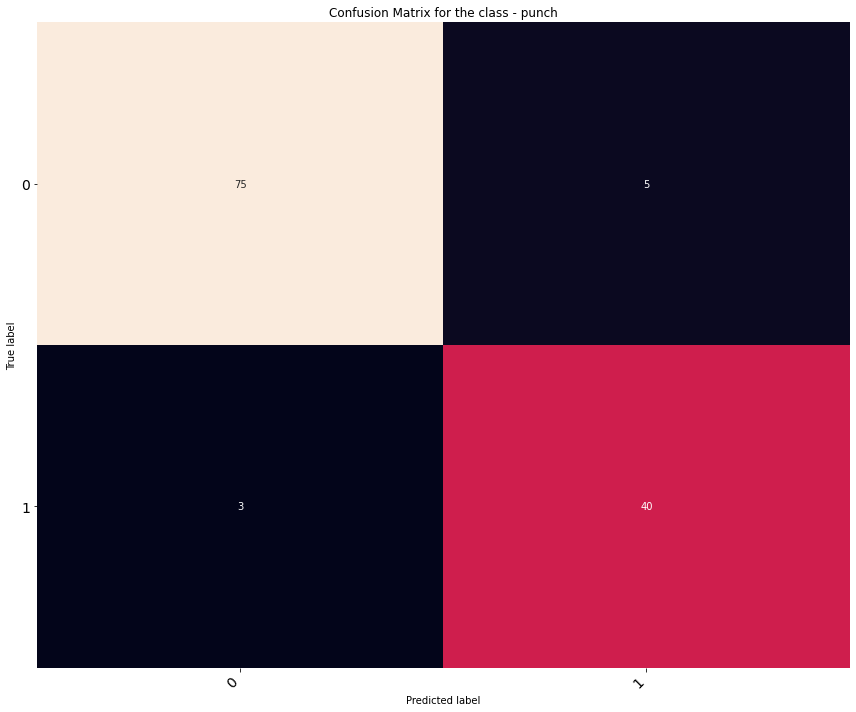

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
print_confusion_matrix(confusion_matrix[1], ax, action_values[1], ["0", "1"])
fig.tight_layout()
plt.show()

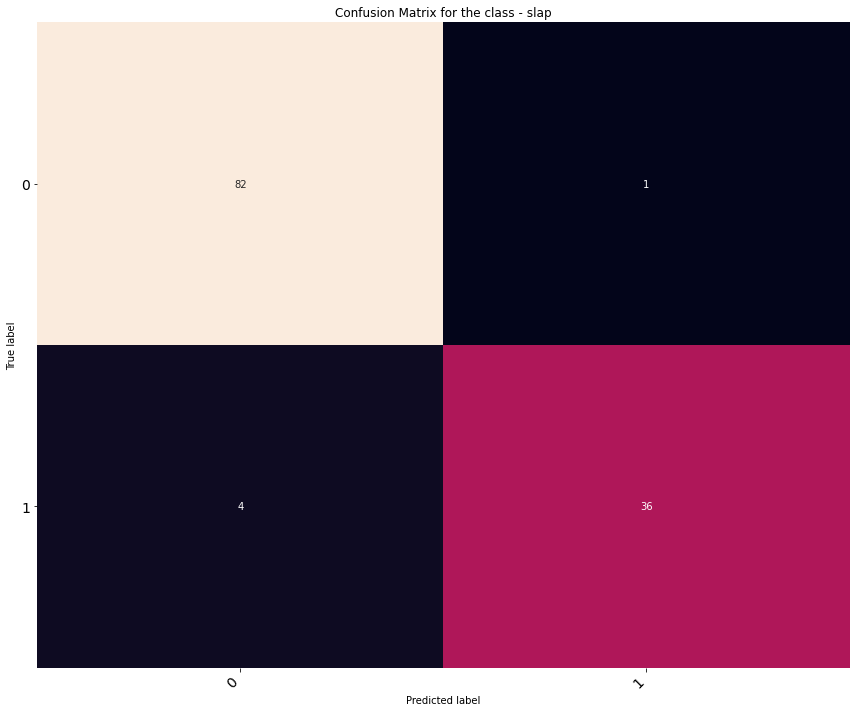

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
print_confusion_matrix(confusion_matrix[2], ax, action_values[2], ["0", "1"])
fig.tight_layout()
plt.show()

### Processing With Pre-trained InceptionV3 with imagenet weight 

In [49]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception_model = InceptionV3(include_top = False, weights = 'imagenet')

In [81]:
# extracting features for training frames
X_train = inception_model.predict(X_train)
X_train.shape

(2171, 5, 5, 2048)

In [82]:
X_val = inception_model.predict(X_val)
X_val.shape

(921, 5, 5, 2048)

In [83]:
# reshaping the training as well as validation frames in single dimension
X_train = X_train.reshape(2171, 5*5*2048)
X_val = X_val.reshape(921, 5*5*2048)

In [84]:
# normalizing the pixel values
max_pixel = X_train.max()
X_train = X_train / max_pixel
X_val = X_val / max_pixel
print(X_train.shape)
print(X_val.shape)

(2171, 51200)
(921, 51200)


In [50]:
# The input shape will be 51200
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(51200,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1024)              52429824  
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)              

In [86]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_weight = ModelCheckpoint('weight1.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [88]:
model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[mcp_weight], batch_size=128)

Epoch 1/50
17/17 [==============================] - 8s 455ms/step - loss: 0.0459 - accuracy: 0.9848 - val_loss: 0.6965 - val_accuracy: 0.9066
Epoch 2/50
17/17 [==============================] - 8s 469ms/step - loss: 0.0666 - accuracy: 0.9797 - val_loss: 0.6176 - val_accuracy: 0.8990
Epoch 3/50
17/17 [==============================] - 8s 458ms/step - loss: 0.0527 - accuracy: 0.9843 - val_loss: 0.6065 - val_accuracy: 0.8979
Epoch 4/50
17/17 [==============================] - 8s 452ms/step - loss: 0.0616 - accuracy: 0.9816 - val_loss: 0.6853 - val_accuracy: 0.9034
Epoch 5/50
17/17 [==============================] - 7s 441ms/step - loss: 0.0488 - accuracy: 0.9857 - val_loss: 0.7090 - val_accuracy: 0.9034
Epoch 6/50
17/17 [==============================] - 7s 440ms/step - loss: 0.0443 - accuracy: 0.9834 - val_loss: 0.5595 - val_accuracy: 0.9034
Epoch 7/50
17/17 [==============================] - 7s 397ms/step - loss: 0.0320 - accuracy: 0.9889 - val_loss: 0.6417 - val_accuracy: 0.9066
Epoch 

In [51]:
model.load_weights("weight1.hdf5")
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1024)              52429824  
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)              

### Applying Built model  on Test data and calculate accuracy with InceptionV3

In [56]:
from scipy import stats as s
predict = []
actual = []
if not os.path.exists(test_frames_path):
    os.makedirs(test_frames_path)

for i in tqdm(range(test.shape[0])):
    video_file = test['Video_url'][i]
    action = test['action'][i]
    video_name_list = video_file.split('/')[-1].split('.')
    video_name_list = video_name_list[:-1]
    video_name = ""
    for n in video_name_list:
        video_name += n
    # capturing the video from the given path
    capture = cv2.VideoCapture(video_file) 
    #frame rate
    frame_rate = capture.get(5)
    count = 0
    files = glob(test_frames_path + '/*')
    #removing all files from folder
    for f in files:
        os.remove(f)
    while(capture.isOpened()):
        #current frame number
        frame_id = capture.get(1) 
        read_correctly, frame = capture.read()
        if not read_correctly:
            break
        if (frame_id % math.floor(frame_rate) == 0):
            # storing the frames in a new folder named train_1
            filename = test_frames_path + "/" + video_name + "_frame{}_".format(count) + action +".jpg"
            count += 1
            cv2.imwrite(filename, frame)
    capture.release()
    
    # reading all the frames from temp folder
    images = glob(test_frames_path + '/*.jpg')
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img / 255
        prediction_images.append(img)
        
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    # extracting features using pre-trained model
    prediction_images = inception_model.predict(prediction_images)
    # converting features in one dimensional array
    prediction_images = prediction_images.reshape(prediction_images.shape[0], 5*5*2048)
    # predicting tags for each array
    prediction = np.argmax(model.predict(prediction_images), axis=-1)
    # appending the mode of predictions in predict list to assign the tag to the video
    predict.append(y_train.columns.values[s.mode(prediction)[0][0]])
    # appending the actual tag of the video
    actual.append(action)

100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [01:49<00:00,  1.13it/s]


In [57]:
from sklearn.metrics import accuracy_score
accuracy_score(predict, actual)*100

88.6178861788618

In [54]:
from sklearn.metrics import precision_score
precision_score(actual, predict, average=None)

array([0.87179487, 0.82608696, 0.97368421])

In [55]:
precision_score(actual, predict, average='micro')

0.8861788617886179

In [58]:
from sklearn.metrics import f1_score
f1_score(actual, predict, average=None)

array([0.86075949, 0.85393258, 0.94871795])

In [59]:
f1_score(actual, predict, average='micro')

0.8861788617886179

In [60]:
from sklearn.metrics import recall_score
recall_score(actual, predict, average=None)

array([0.85      , 0.88372093, 0.925     ])

In [61]:
recall_score(actual, predict, average='micro')

0.8861788617886179

In [62]:
from sklearn.metrics import multilabel_confusion_matrix
confusion_matrix = multilabel_confusion_matrix(actual, predict, labels=action_values)
# confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
print(confusion_matrix)

[[[78  5]
  [ 6 34]]

 [[72  8]
  [ 5 38]]

 [[82  1]
  [ 3 37]]]


In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

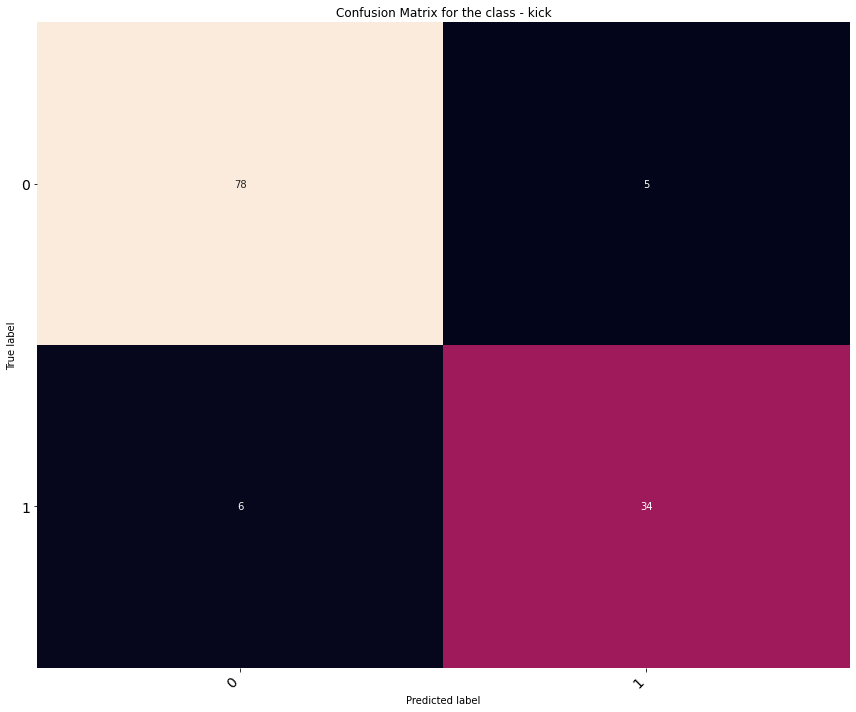

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
print_confusion_matrix(confusion_matrix[0], ax, action_values[0], ["0", "1"])
fig.tight_layout()
plt.show()

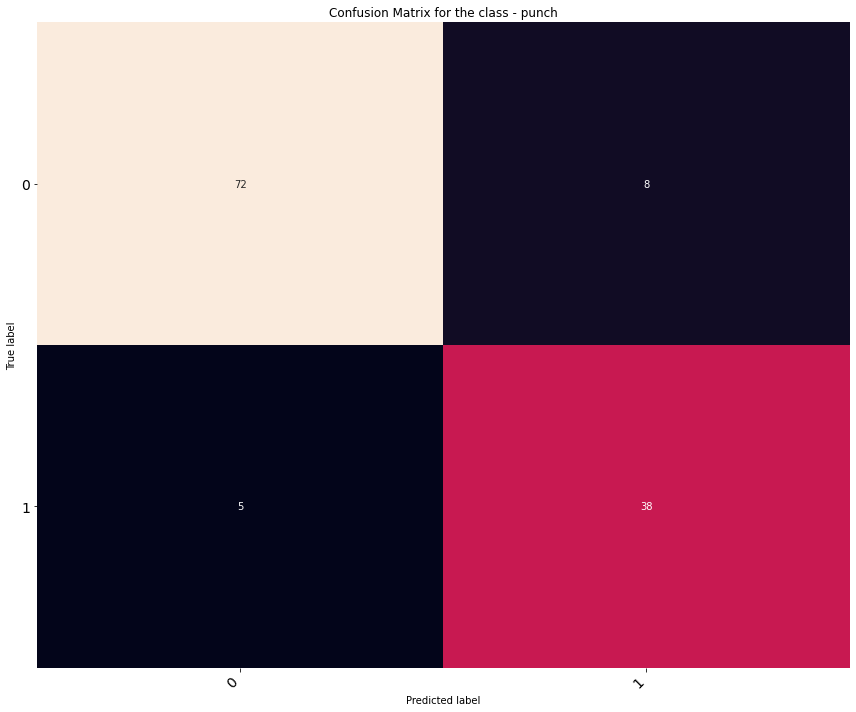

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
print_confusion_matrix(confusion_matrix[1], ax, action_values[1], ["0", "1"])
fig.tight_layout()
plt.show()

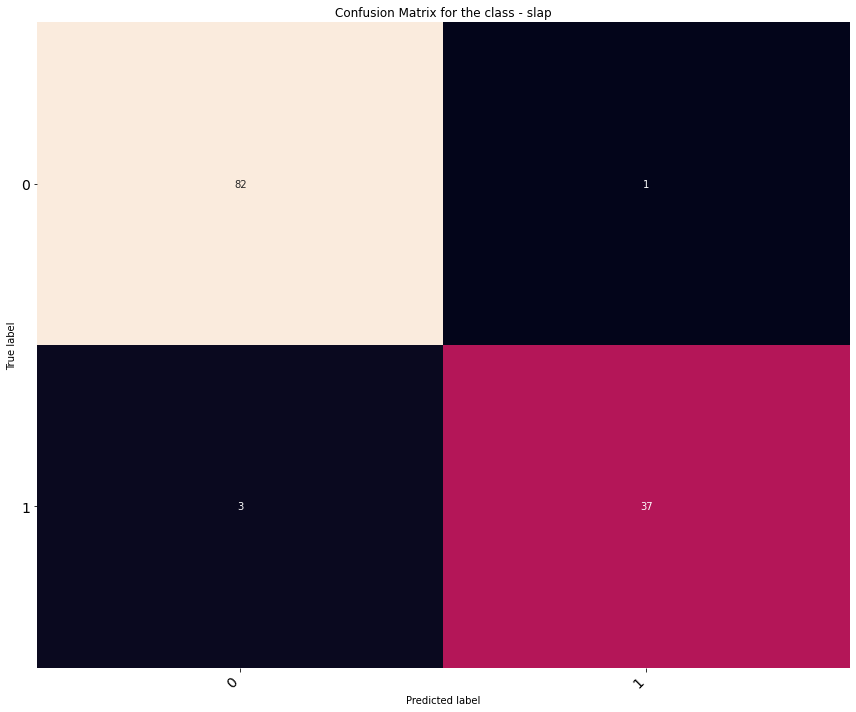

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
print_confusion_matrix(confusion_matrix[2], ax, action_values[2], ["0", "1"])
fig.tight_layout()
plt.show()

### Processing With Pre-trained ResNet50 with imagenet weight

In [70]:
from tensorflow.keras.applications import ResNet50
resnet_model = ResNet50(include_top=False, weights="imagenet")

In [108]:
X_train = resnet_model.predict(X_train)
X_train.shape

(2171, 7, 7, 2048)

In [109]:
X_val = resnet_model.predict(X_val)
X_val.shape

(921, 7, 7, 2048)

In [110]:
X_train = X_train.reshape(2171, 7*7*2048)
X_val = X_val.reshape(921, 7*7*2048)

In [111]:
max_pixel = X_train.max()
X_train = X_train / max_pixel
X_val = X_val / max_pixel
print(X_train.shape)
print(X_val.shape)

(2171, 100352)
(921, 100352)


In [67]:
# The input shape will be 100352
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(100352,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 1024)              102761472 
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)              

In [113]:
from keras.callbacks import ModelCheckpoint
mcp_weight = ModelCheckpoint('weight2.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [114]:
model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[mcp_weight], batch_size=128)

Epoch 1/50
17/17 [==============================] - 23s 1s/step - loss: 1.2903 - accuracy: 0.3459 - val_loss: 1.1094 - val_accuracy: 0.3181
Epoch 2/50
17/17 [==============================] - 27s 2s/step - loss: 1.1570 - accuracy: 0.3399 - val_loss: 1.0996 - val_accuracy: 0.3181
Epoch 3/50
17/17 [==============================] - 26s 2s/step - loss: 1.1123 - accuracy: 0.3496 - val_loss: 1.0926 - val_accuracy: 0.3865
Epoch 4/50
17/17 [==============================] - 14s 809ms/step - loss: 1.1080 - accuracy: 0.3542 - val_loss: 1.0932 - val_accuracy: 0.3865
Epoch 5/50
17/17 [==============================] - 14s 820ms/step - loss: 1.1026 - accuracy: 0.3671 - val_loss: 1.0942 - val_accuracy: 0.3865
Epoch 6/50
17/17 [==============================] - 14s 800ms/step - loss: 1.0995 - accuracy: 0.3630 - val_loss: 1.0952 - val_accuracy: 0.3865
Epoch 7/50
17/17 [==============================] - 14s 797ms/step - loss: 1.0960 - accuracy: 0.3657 - val_loss: 1.0947 - val_accuracy: 0.3865
Epoch 8/

In [68]:
model.load_weights("weight2.hdf5")
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 1024)              102761472 
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)              

### Applying Built model  on Test data and calculate accuracy with Resnet50

In [71]:
from scipy import stats as s
predict = []
actual = []
if not os.path.exists(test_frames_path):
    os.makedirs(test_frames_path)

for i in tqdm(range(test.shape[0])):
    video_file = test['Video_url'][i]
    action = test['action'][i]
    video_name_list = video_file.split('/')[-1].split('.')
    video_name_list = video_name_list[:-1]
    video_name = ""
    for n in video_name_list:
        video_name += n
    # capturing the video from the given path
    capture = cv2.VideoCapture(video_file) 
    #frame rate
    frame_rate = capture.get(5)
    count = 0
    files = glob(test_frames_path + '/*')
    #removing all files from folder
    for f in files:
        os.remove(f)
    while(capture.isOpened()):
        #current frame number
        frame_id = capture.get(1) 
        read_correctly, frame = capture.read()
        if not read_correctly:
            break
        if (frame_id % math.floor(frame_rate) == 0):
            # storing the frames in a new folder named train_1
            filename = test_frames_path + "/" + video_name + "_frame{}_".format(count) + action +".jpg"
            count += 1
            cv2.imwrite(filename, frame)
    capture.release()
    
    # reading all the frames from temp folder
    images = glob(test_frames_path + '/*.jpg')
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img / 255
        prediction_images.append(img)
        
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    # extracting features using pre-trained model
    prediction_images = resnet_model.predict(prediction_images)
    # converting features in one dimensional array
    prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*2048)
    # predicting tags for each array
    prediction = np.argmax(model.predict(prediction_images), axis=-1)
    # appending the mode of predictions in predict list to assign the tag to the video
    predict.append(y_train.columns.values[s.mode(prediction)[0][0]])
    # appending the actual tag of the video
    actual.append(action)

100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [02:01<00:00,  1.01it/s]


In [72]:
accuracy_score(predict, actual)*100

68.29268292682927

In [73]:
from sklearn.metrics import precision_score
precision_score(actual, predict, average=None)

array([0.72972973, 0.74285714, 0.60784314])

In [74]:
precision_score(actual, predict, average='micro')

0.6829268292682927

In [75]:
from sklearn.metrics import f1_score
f1_score(actual, predict, average=None)

array([0.7012987 , 0.66666667, 0.68131868])

In [76]:
f1_score(actual, predict, average='micro')

0.6829268292682927

In [77]:
from sklearn.metrics import recall_score
recall_score(actual, predict, average=None)

array([0.675     , 0.60465116, 0.775     ])

In [78]:
recall_score(actual, predict, average='micro')

0.6829268292682927

In [79]:
from sklearn.metrics import multilabel_confusion_matrix
confusion_matrix = multilabel_confusion_matrix(actual, predict, labels=action_values)
print(confusion_matrix)

[[[73 10]
  [13 27]]

 [[71  9]
  [17 26]]

 [[63 20]
  [ 9 31]]]


In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

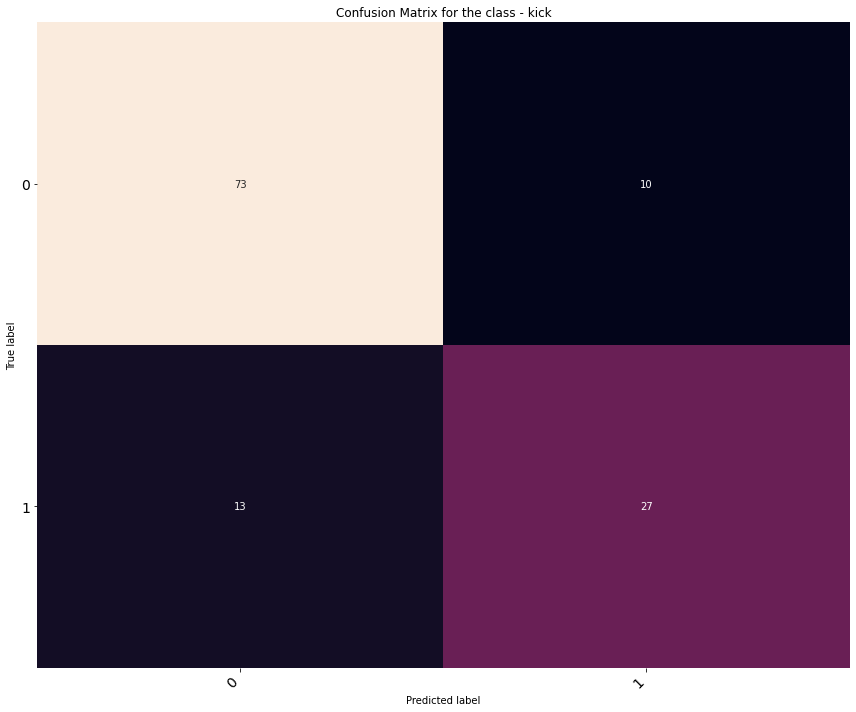

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
print_confusion_matrix(confusion_matrix[0], ax, action_values[0], ["0", "1"])
fig.tight_layout()
plt.show()

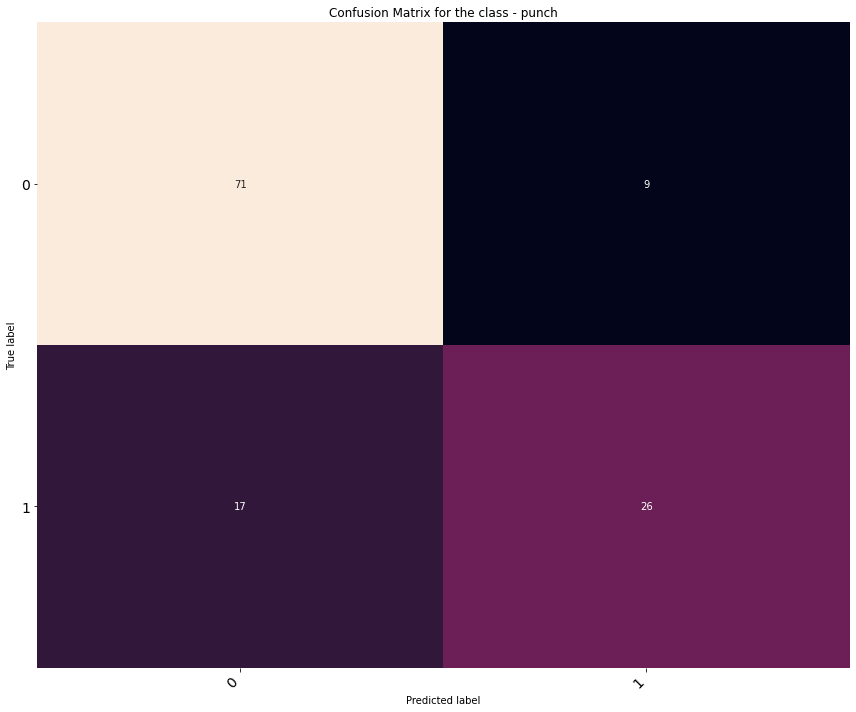

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
print_confusion_matrix(confusion_matrix[1], ax, action_values[1], ["0", "1"])
fig.tight_layout()
plt.show()

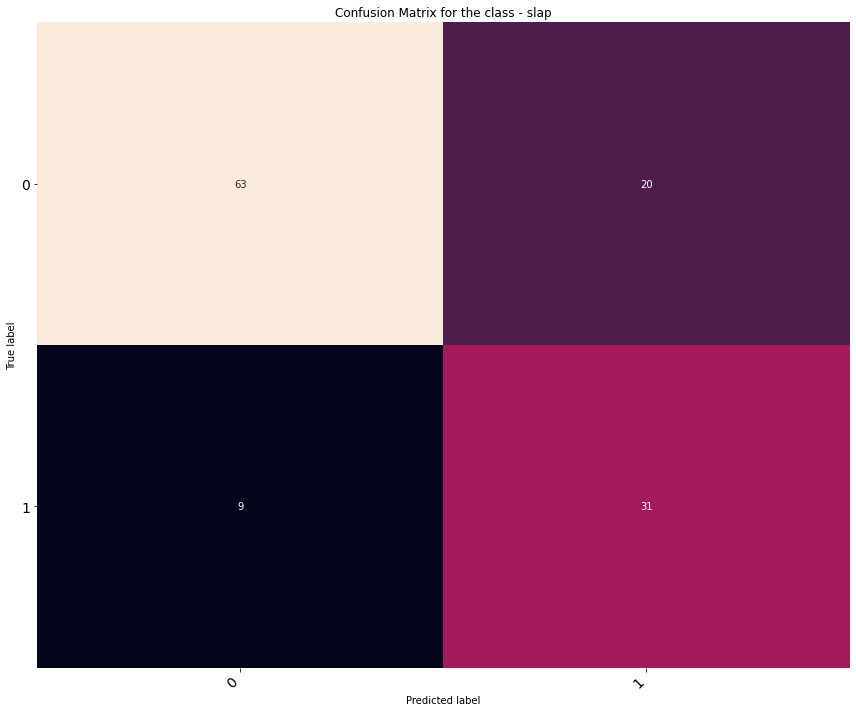

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
print_confusion_matrix(confusion_matrix[2], ax, action_values[2], ["0", "1"])
fig.tight_layout()
plt.show()